In [1]:
import gym
import numpy as np
import tensorflow as tf
from tensorflow.contrib import slim

import os
import itertools

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot')

In [2]:
env = gym.make('CartPole-v0')
n_features = env.observation_space.shape[0]
n_actions = env.action_space.n

[2016-12-22 01:35:49,291] Making new env: CartPole-v0


In [3]:
def make_normalization(env):
    ''' Normalizes the state space '''
    states_sample = np.array([env.observation_space.sample() for _ in range(100000)])
    states_mean = np.mean(states_sample, axis=0)
    states_std = np.std(states_sample, axis=0)
    
    def normalize_state(state):
        return (state - states_mean) / states_std
    
    return normalize_state

In [4]:
def reward_return(rewards, discount_factor=0.99):
    ''' Calculate the return from step t '''
    G = []
    G_sum = 0
    # Start calculating from the last reward
    for t, reward in enumerate(reversed(rewards)):
        G_sum = G_sum * discount_factor + reward
        G.append(G_sum)
    # Revert list again
    G.reverse()
    return G

In [5]:
def convolve(x, window_size):
    ''' Take the mean of array over window '''
    weigths = np.repeat(1.0, window_size) / window_size
    return np.convolve(np.mean(x, axis=0), weigths, 'same')

In [6]:
class Policy:
    ''' Define a neural network that will be used as a policy '''
    def __init__(self, learning_rate):
        # Placeholders
        self.X = tf.placeholder(name='input', shape=[None, n_features], dtype=tf.float32)
        self.G = tf.placeholder(name='return', shape=[None], dtype=tf.float32)
        self.action = tf.placeholder(name='chosen_action', shape=[None], dtype=tf.int32)
        # Network body
        self.hidden = slim.fully_connected(inputs=self.X, num_outputs=16)
        self.output = slim.fully_connected(inputs=self.hidden, num_outputs=n_actions, activation_fn=tf.nn.softmax)        
        
        # SGD step
        # Get only the actions that were chosen
        batch_size = tf.shape(self.X)[0]   
        actions_ids = tf.range(batch_size) * tf.shape(self.output)[1] + self.action
        chosen_actions = tf.gather(tf.reshape(self.output, [-1]), actions_ids)        
        eligibility = tf.log(chosen_actions)
        # Change the likelihood of taken action using the return (self.G)        
        loss = -tf.reduce_mean(self.G * eligibility)
        opt = tf.train.AdamOptimizer(learning_rate)
        # We should perform gradient ascent in the likelihood of specified action
        # which is the same as performing gradient descent on the negative of the loss
        self.train_op = opt.minimize(loss)
        
    def predict(self, sess, state):
        ''' Return action probabilities'''
        return sess.run(self.output, feed_dict={self.X: state})
    
    def update(self, sess, state, action, returns):
        ''' Perform SGD '''
        feed_dict = {self.X: state, self.action: action, self.G: returns}
        sess.run(self.train_op, feed_dict=feed_dict)

In [7]:
def test_updates(learning_rate, batch_size=100):
    ''' Test if the weigth updates are giving the desired outputs '''
    # Create a new policy
    tf.reset_default_graph()
    policy = Policy(learning_rate=learning_rate)
    state = [env.observation_space.sample() for _ in range(batch_size)]
    # Normalize states
    normalizer = make_normalization(env)
    state = normalizer(state)
    # Tuples of returns and what should happen to actions
    fake_returns = [(100, 'increase'), (-100, 'decrease')]
    for action in range(n_actions):
        actions = action * np.ones(batch_size)
        for fake_return, expected in fake_returns:
            # Reinitialize session because ADAM optimizer builds momentum
            with tf.Session() as sess:
                tf.initialize_all_variables().run()
                # Compare new and old probabilities
                old_probs = policy.predict(sess, state)
                policy.update(sess, state, actions, [fake_return])
                new_probs = policy.predict(sess, state)        
                print('Action {} probability should {}:'.format(action, expected), end=' ')
                print(np.mean(new_probs - old_probs, axis=0))

In [8]:
def train(n_episodes, learning_rate, record_every_steps=None):

    # Create new policy
    tf.reset_default_graph()
    policy = Policy(learning_rate)
    
    if record_every_steps is not None:
        # If record video
        video_dir = 'videos'
        video_path = os.path.join(video_dir, 'REINFORCE')
        # If directory dont exists, create one
        if not os.path.exists(video_path):
            os.makedirs(video_path)
        
        env.monitor.start(directory=video_path,
                          force=True,
                          video_callable=lambda counter: counter % record_every_steps == 0)

    with tf.Session() as sess:
        tf.initialize_all_variables().run()
        length = []

        for i_episode in range(n_episodes):
            state = env.reset()
            experience = []

            for t in itertools.count():
                # Choose an action
                action_probs = policy.predict(sess, [state])
                action = np.random.choice(np.arange(n_actions), p=np.squeeze(action_probs))
                # Take the action
                next_state, reward, done, _ = env.step(action)
                # Store experience
                experience.append((state, action, reward))
                # Update state and please, dont run forever
                if done or t == 5000:
                    break
                state = next_state

            # Unpack episode
            ep_states, ep_actions, ep_rewards = map(np.array, zip(*experience))
            ep_returns = reward_return(ep_rewards)
            # Update weigths
            policy.update(sess, ep_states, ep_actions, ep_returns)
            # Store episode length
            length.append(t)

            # Print information
            print('\rEpisode {}/{} | Length: {}'.format(i_episode, n_episodes, t), end='', flush=True)
    
    env.monitor.close()
    return length

In [9]:
test_updates(learning_rate=1e-2)

/home/quazar/anaconda3/lib/python3.5/site-packages/tensorflow/python/ops/gradients.py:90: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Action 0 probability should increase: [ 0.04048157 -0.04048157]
Action 0 probability should decrease: [-0.03365801  0.03365801]
Action 1 probability should increase: [-0.03975503  0.03975504]
Action 1 probability should decrease: [ 0.04114689 -0.04114689]


In [10]:
without_monitor = [train(n_episodes=1000, learning_rate=5e-3, record_every_steps=None) for _ in range(10)]

/home/quazar/anaconda3/lib/python3.5/site-packages/tensorflow/python/ops/gradients.py:90: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Episode 999/1000 | Length: 124

In [14]:
with_monitor = [train(n_episodes=1000, learning_rate=5e-3, record_every_steps=200) for _ in range(10)]

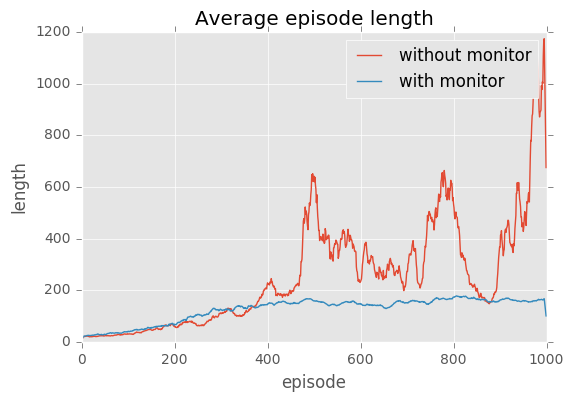

In [13]:
# Plot episodes length smoothed over a window size of 10
plt.plot(convolve(without_monitor, 10), label='without monitor')
plt.plot(convolve(with_monitor, 10), label='with monitor')
plt.title('Average episode length')
plt.xlabel('episode')
plt.ylabel('length')
plt.legend()